In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

In [12]:
data=pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [13]:
if data.isnull().values.any():
    data=data.dropna()
    print('Удалили пропуски')
else:
    print('Пропусков небыло')

Пропусков небыло


In [14]:
data['Month']=pd.to_datetime(data['Month'], format='%Y-%m')

In [15]:
data.set_index('Month', inplace=True)

In [16]:
if data.index.is_monotonic_increasing:
    print('Индекс монотонно возрастает.')
else:
    print('Нет монотонного возрастания индекса')

Индекс монотонно возрастает.


In [17]:
filtred_data=data['1952':'1957']


In [18]:
decomposition=seasonal_decompose(filtred_data, model='multiplicative')

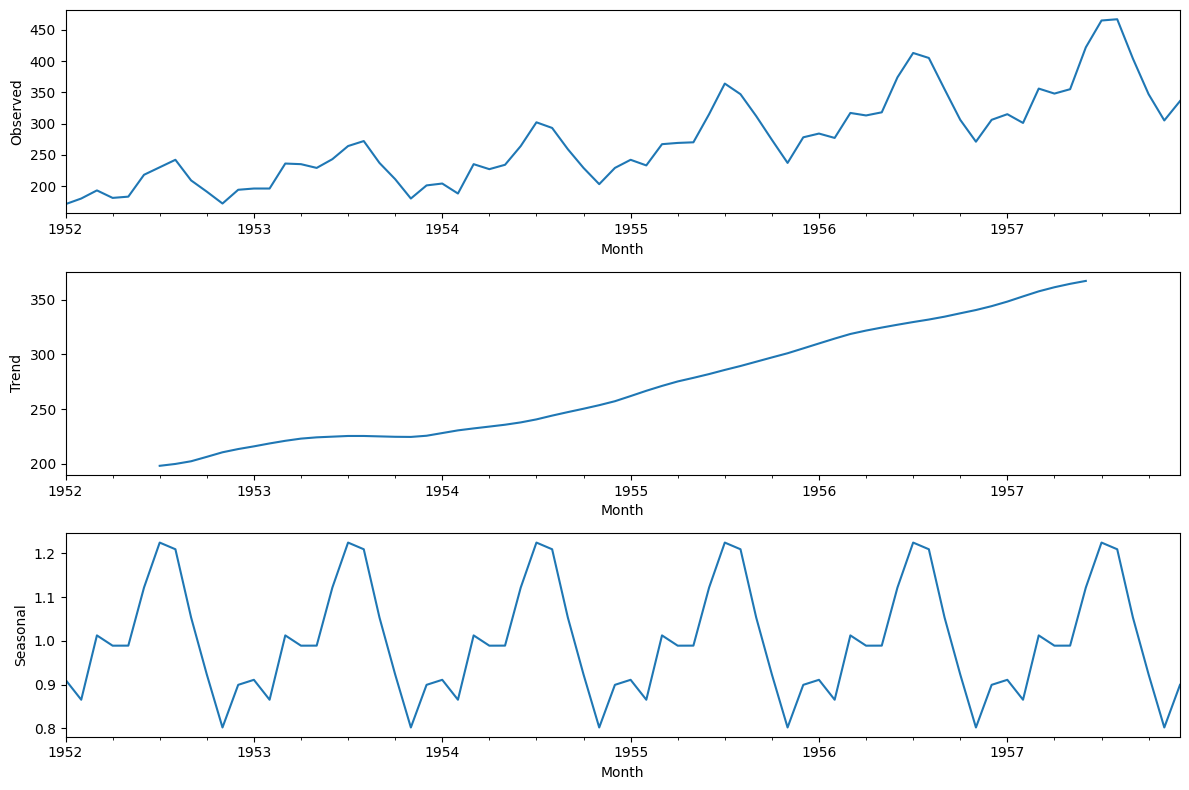

In [21]:
fig, (ax1, ax2, ax3)=plt.subplots(3,1,figsize=(12,8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
plt.tight_layout()
plt.show()


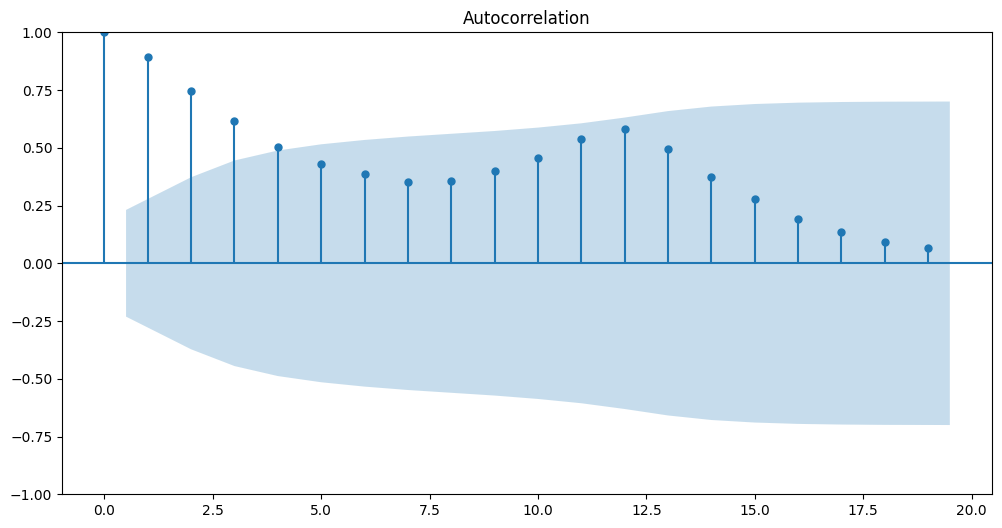

In [22]:
fig, ax = plt.subplots(figsize=(12,6))
plot_acf(filtred_data, ax=ax)
plt.show()

График автокорреляции показывает положительную автокорреляцию на больших лагах, что часто свидетельствует о наличии тренда. На левых лагах, кратных 12, корреляция особенно высока, что дополнительно подтверждает наличие годовой сезонности.
В целом, временной ряд для данных о пассажирских перевозках не является стационарным из-за наличия положительного тренда и сезонности, что подтверждается и графиком автокорреляции.